## 5-3. Quantum Approximate Optimazation Algorithm (QAOA): 量子近似最適化アルゴリズム

### 概要

この節では、NISQアルゴリズムの一つと考えられる Quantum Approximate Optimazation Algorithm (QAOA; 量子近似最適化アルゴリズム)を学ぶ。QAOAは、量子アニーリングと同様に、組み合わせ最適化問題の解を求めるためのアルゴリズムである。

### 問題設定
QAOAでは、$z = z_{1}z_{2}\cdots z_{n} \: (z_i =0,1)$ という$n$桁のビット列$z$に関して、コスト関数$C(z) = \sum_\alpha C_\alpha(z)$が最小になるような$z$を探す問題を考える。$C_\alpha(z)$はビット列$z$を引数にとる何らかの関数で、ここでは特に、イジングモデル的な$C_\alpha(z) = z_i\cdot z_j$といった項を考えれば良い。

この最小化問題を解くために、$n$**ビットの量子系を用いる**。そして、$\beta = (\beta^{(1)}, \cdots \beta^{(p)}), \gamma = (\gamma^{(1)}, \cdots \gamma^{(p)})$ をパラメータとして、次のような量子状態を考える。

\begin{align}
&|s\rangle = |+\rangle^{\otimes n} = \frac{1}{2^{n/2}} \sum_{z=0}^{2^{n}-1} |z\rangle, \\
&|\beta, \gamma \rangle = U_X(\beta^{(p)}) U_C(\gamma^{(p)}) \cdots U_X(\beta^{(1)}) U_C(\gamma^{(1)}) |s\rangle. 
\end{align}

ここで $|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$は$X$演算子の固有状態$X|+\rangle=|+\rangle$であり、 $U_C(\gamma), U_X(\beta)$ は次のように定義される。

$$
U_C(\gamma^{(i)}) = e^{-i\gamma^{(i)} C(Z)} = \prod_{\alpha} e^{-i\gamma^{(i)} C_{\alpha}(Z)}, \\
U_X(\beta^{(i)}) = e^{-i\beta^{(i)} \sum_{j=1}^n X_j} = \prod_{j =1}^n e^{-i\beta^{(i)} X_j}.
$$

状態$|\beta, \gamma \rangle$やこれらの演算子の意味を説明するには量子アニーリングの知識が必要になる。とりあえず、QAOAを使うだけならこういうものだと受け入れて使ってしまえば良い。    
（なお、$C(Z)$というのはビット列を引数にとる関数$C(z)$の入力にパウリ演算子$Z_1\cdots Z_n$と代入したものであることに注意。）

そして、$F(\beta, \gamma) = \langle{\bf \gamma, \,\beta}|C(Z)|{\bf \gamma, \,\beta}\rangle$ を最小にするような$\beta,\gamma$を探索することで、元々の最適化問題の答えを探そうとするのが、QAOAアルゴリズムである。

### QAOAアルゴリズムの手順
具体的なQAOAアルゴリズムの手順は以下の通りである。

1. 量子コンピュータ上で重ね合わせ状態$|s\rangle = |+\rangle^{\otimes n}$を作る。
2. パラメータ$\beta, \gamma$に応じて、量子状態に$U_C(\gamma^{(i)}),U_X(\beta^{(i)})$をかけていき、状態$|\beta, \gamma \rangle$を得る。
3. 量子コンピュータを用いて $\langle \beta, \gamma |C(Z)|\beta, \gamma \rangle$ を測定する。
4. 古典コンピュータで、$\langle \beta, \gamma |C(Z)|\beta, \gamma \rangle$ がより小さくなるようにパラメータ $\beta, \gamma$ をアップデートする。
5. 1〜4を繰り返し、最適な $\beta^*, \gamma^*$ を得る。
6. 状態 $|\beta^*, \gamma^* \rangle$ に対して、$z$方向の射影測定を複数回実行し、**得られた（良さそうな）測定結果** $z_1\cdots z_n$ **を元々の最適化問題の解として採用**する。（注：測定結果 $z_1\cdots z_n$ は古典ビット）

少々ややこしいので、具体例を実装しながら確認していこう。

### 実装：Maxcut問題をQAOAで解く

ここでは具体例としてMaxcut問題という問題を取り上げる。   
[Maxcut問題](https://ja.wikipedia.org/wiki/カット_(グラフ理論))は、$n$個の頂点を持つグラフ（例えば下図）を２つに分割する時に、分割される辺の数の最大値を求める問題である。

![maxcut-example](figs/5/maxcut_example.png)
(図の出典：Wikipedia [カット_(グラフ理論)](https://ja.wikipedia.org/wiki/カット_(グラフ理論)))

この問題をQAOAで扱えるような最適化問題に帰着させるには、以下のようにする。
頂点を２つのグループに分けた時、片方のグループに属する頂点に+1、もう一方のグループに-1を付与するとすれば、コスト関数

$$
C(z) = -\frac{1}{2} \sum_{\text{辺で繋がっている頂点}i,j} ( 1 - z_i z_j)
$$

は (グループ分けによって分割される辺の数) $\times (-1)$ を表す。
ゆえに、$C(z)$を最小化するようなビット列$z=z_1\cdots z_n$を見つければ、分割する辺の数を最小化するような頂点の分け方を見つけたことになる。

以下では、長方形(頂点が４つの図形)のmaxcut問題を解いてみよう。
![maxcut](figs/5/maxcut_4nodes.png)

この場合、$C(Z)$は

$$
\begin{eqnarray}
C(Z) &=& -\frac{1}{2}(1-Z_{0}Z_{1})-\frac{1}{2}(1-Z_{1}Z_{2})-\frac{1}{2}(1-Z_{2}Z_{3})-\frac{1}{2}(1-Z_{3}Z_{1})\\
&=&\frac{1}{2}(Z_{0}Z_{1}+Z_{1}Z_{2}+Z_{2}Z_{3}+Z_{3}Z_{1}) - 2
\end{eqnarray}
$$

となる。第二項は定数だから、以下では

$$
C(Z) = \frac{1}{2}(Z_{0}Z_{1}+Z_{1}Z_{2}+Z_{2}Z_{3}+Z_{3}Z_{1}) 
$$

とおく。

#### $p=1$の場合
まずは$p=1$の場合の実装をやってみよう。この時、$|\beta, \gamma \rangle = U_X(\beta^{(1)}) U_C(\gamma^{(1)}) |s\rangle$ である。

$U_C(\gamma^{(1)}) = \prod_{i=0}^3 e^{-i\gamma^{(1)} Z_i Z_{i+1} }$ を実装するには、4-2節でも用いた関係

$$
e^{-i \delta Z_i Z_{i+1}}　= \operatorname{CNOT}_{i,i+1} \cdot e^{-i\delta Z_{i+1}} \cdot \operatorname{CNOT}_{i,i+1}.
$$

を使えば良い。（行列に直して計算すると、合っていることがわかる。）

以上を踏まえて、$|\beta, \gamma \rangle$ を構成して $\langle \beta, \gamma | C(Z) |\beta, \gamma \rangle$ を測定し、それを最小化する工程を実装するとこのようになる。

In [ ]:
## Google Colaboratoryの場合・Qulacsがインストールされていないlocal環境の場合のみ実行してください
!pip install qulacs

In [1]:
#必要なライブラリをインポートする
from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from qulacs.gate import H, CNOT, RX, RZ
from scipy.optimize import minimize
import numpy as np

## 頂点の数
n = 4 

## C(Z)をqulacs.Observableとして定義
cost_observable = Observable(n) 
for i in range(n):
    cost_observable.add_operator( PauliOperator("Z {:} Z {:}".format(i, (i+1)%n), 0.5) )

# circuit に U_C(gamma) を加える関数
def add_U_C(circuit, gamma):
    for i in range(n):
        j = (i+1) % n
        circuit.add_CNOT_gate(i, j)
        circuit.add_gate(RZ(j, -2*gamma)) ## qulacsでは RZ(theta)=e^{i*theta/2*Z}
        circuit.add_CNOT_gate(i, j)
    return circuit
    
# circuit に U_X(beta) を加える関数
def add_U_X(circuit, beta):
    for i in range(n):
        circuit.add_gate(RX(i, -2*beta))
    return circuit

# p=1 の |beta, gamma> を作って <beta, gamma| C(Z) |beta, gamma> を返す関数
# x = [beta, gamma]
def QAOA_output_onelayer(x): 
    beta, gamma = x

    circuit = QuantumCircuit(n)
    ## 重ね合わせを作るため、アダマールゲートをかける
    for i in range(n):
        circuit.add_H_gate(i)
    ## U_C, U_Xをかける
    circuit =  add_U_C(circuit, gamma)
    circuit =  add_U_X(circuit, beta)

    ## |beta, gamma>を作る
    state = QuantumState(n)
    state.set_zero_state()                     
    circuit.update_quantum_state(state)
    return cost_observable.get_expectation_value(state)                 

## 初期値
x0 = np.array( [0.1, 0.1 ])

## scipy.minimize を用いて最小化
result = minimize(QAOA_output_onelayer, x0, options={'maxiter':500}, method='powell')
print(result.fun) # 最適化後の値
print(result.x) # 最適化後の(beta, gamma)

-0.999999999499185
[1.17809152 0.39269362]


最小値-1と、その時の$\beta^{(1)}, \gamma^{(1)}$の値が得られた。   
この最適な状態 $|\beta, \gamma\rangle$ を$z$方向に射影測定した時にどのような値が得られるか、具体的に見てみよう。

In [2]:
# 最適なbeta, gammaを使って |beta, gamma> をつくる
beta_opt, gamma_opt = result.x

circuit = QuantumCircuit(n)
## 重ね合わせを作るため、アダマールゲートをかける
for i in range(n):
    circuit.add_H_gate(i)
## U_C, U_Xをかける
circuit =  add_U_C(circuit, gamma_opt)
circuit =  add_U_X(circuit, beta_opt)

## |beta, gamma>を作る
state = QuantumState(n)
state.set_zero_state()                     
circuit.update_quantum_state(state)

## z方向に観測した時の確率分布を求める. (状態ベクトルの各成分の絶対値の二乗=観測確率)
probs = np.abs(state.get_vector())**2
print(probs)

[0.01562503 0.01562568 0.01562568 0.0781236  0.01562568 0.26562503
 0.0781236  0.01562568 0.01562568 0.0781236  0.26562503 0.01562568
 0.0781236  0.01562568 0.01562568 0.01562503]


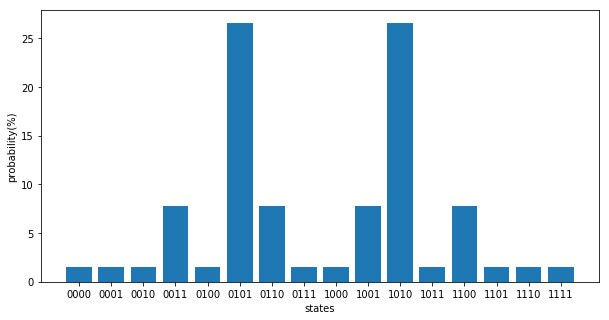

In [5]:
# プロットする
import matplotlib.pyplot as plt
%matplotlib inline

## z方向に射影測定した時に得られる可能性があるビット列
z_basis = [format(i,"b").zfill(n) for i in range(probs.size)]

plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis, probs*100)
plt.show()

つまり、$z$方向の射影測定を行うと、`0101` か `1010` が測定される確率が高いことが分かった。これらのビット列は頂点1と頂点3、頂点2と頂点4が同じグループになるということを意味するから、以下のような分割を表している。

![maxcut-p-1](figs/5/maxcut_result_p1.png)

この時、図形を分割する曲線が横切る辺の数は4本であり、この図形を分割する時に通る辺の数の最大値である。

よって、最適化した$|\beta, \gamma\rangle$に射影測定を行い、ある程度多数の測定結果を行って測定確率が高いビット列を採用すれば、もともと解きたかった最適化問題$C(z)$の解が得られた、ということになる。   
一応、これでめでたしめでたし、と言えるのだが、最適化したコスト関数$\langle \beta, \gamma | C(Z) |\beta, \gamma \rangle$ の値は−1だったことを思い出してほしい。$\langle 0101 | C(Z) |0101 \rangle = \langle 1010 | C(Z) |1010 \rangle = -2$なので、コスト関数については正しい値が得られていない！ これはvariationalな状態$|\beta, \gamma \rangle$ が十分な表現能力を持たず、真の解$|0101\rangle, |1010\rangle$ を表現できなかったことに由来する。

そこで、回路をより複雑にした$p=2$の場合に結果がどう変わるか見てみよう。

※ ちなみに、$|\beta, \gamma\rangle$に100回の測定を行ってビット列$z$を100通り得て、それぞれについて$C(z)$を古典コンピュータで計算してみて最も良かったものを採用する、といった戦略を用いれば、このような問題は生じないかもしれない。

#### $p=2$の場合

-1.9999996223652372
[1.01150163 1.11872823 0.45213228 0.55937865]
[1.10913271e-15 9.96406007e-09 9.96406007e-09 2.72762241e-08
 9.96406007e-09 4.99999906e-01 2.72762241e-08 9.96406007e-09
 9.96406007e-09 2.72762241e-08 4.99999906e-01 9.96406007e-09
 2.72762241e-08 9.96406007e-09 9.96406007e-09 1.10913271e-15]


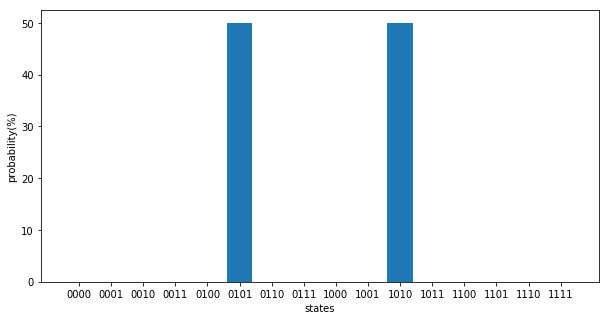

In [8]:
#必要なライブラリをインポートする
from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from qulacs.gate import H, CNOT, RX, RZ
from scipy.optimize import minimize
import numpy as np

## 頂点の数
n = 4 

## C(Z)をqulacs.Observableとして定義
cost_observable = Observable(n) 
for i in range(n):
    cost_observable.add_operator( PauliOperator("Z {:} Z {:}".format(i, (i+1)%n), 0.5) )

# circuit に U_C(gamma) を加える関数
def add_U_C(circuit, gamma):
    for i in range(n):
        j = (i+1) % n
        circuit.add_CNOT_gate(i, j)
        circuit.add_gate(RZ(j, -2*gamma)) ## qulacsでは RZ(theta)=e^{i*theta/2*Z}
        circuit.add_CNOT_gate(i, j)
    return circuit
    
# circuit に U_X(beta) を加える関数
def add_U_X(circuit, beta):
    for i in range(n):
        circuit.add_gate(RX(i, -2*beta))
    return circuit

# p=2 の |beta, gamma> を作って <beta, gamma| C(Z) |beta, gamma> を返す関数
# x = [beta0, beta1, gamma0, gamma1]
def QAOA_output_twolayer(x): 
    beta0, beta1, gamma0, gamma1 = x

    circuit = QuantumCircuit(n)
    ## 重ね合わせを作るため、アダマールゲートをかける
    for i in range(n):
        circuit.add_H_gate(i)
    ## U_C, U_Xをかける
    circuit =  add_U_C(circuit, gamma0)
    circuit =  add_U_X(circuit, beta0)
    circuit =  add_U_C(circuit, gamma1)
    circuit =  add_U_X(circuit, beta1)

    ## |beta, gamma>を作る
    state = QuantumState(n)
    state.set_zero_state()                     
    circuit.update_quantum_state(state)
    return cost_observable.get_expectation_value(state)                 

## 初期値
x0 = np.array( [0.1, 0.1, 0.2, 0.3 ])

## scipy.minimize を用いて最小化
result = minimize(QAOA_output_twolayer, x0, options={'maxiter':500}, method='powell')
print(result.fun) # 最適化後の値
print(result.x) # 最適化後の[beta0, beta1, gamma0, gamma1]

## 最適化後の状態を測定した時の確率分布を調べる
beta0, beta1, gamma0, gamma1 = result.x

circuit = QuantumCircuit(n)
## 重ね合わせを作るため、アダマールゲートをかける
for i in range(n):
    circuit.add_H_gate(i)
## U_C, U_Xをかける
circuit =  add_U_C(circuit, gamma0)
circuit =  add_U_X(circuit, beta0)
circuit =  add_U_C(circuit, gamma1)
circuit =  add_U_X(circuit, beta1)

## |beta, gamma>を作る
state = QuantumState(n)
state.set_zero_state()                     
circuit.update_quantum_state(state)

## 状態ベクトルの各成分の絶対値の二乗=観測確率
probs = np.abs(state.get_vector())**2
print(probs)

## z方向に射影測定した時に得られる可能性があるビット列
z_basis = [format(i,"b").zfill(n) for i in range(probs.size)]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis, probs*100)
plt.show()

$p=1$の時に比べ、圧倒的に大きい確率で真の解$|0101\rangle, |1010\rangle$が得られる確率が高いことが分かる。また、コスト関数の値も正しく−2に近づいている。

このように、QAOAを用いる際には、変分量子回路の複雑さ$p$の大きさにも注意しながら実装する必要があるだろう。

### 参考文献

[1] E. Farhi, J. Goldstone, and S. Gutmann, “A Quantum Approximate Optimization Algorithm”, [arXiv:1411.4028](https://arxiv.org/abs/1411.4028) (2014).

[2] Eddie Farhi: A Quantum Approximate Optimization Algorithm, https://www.youtube.com/watch?v=J8y0VhnISi8